# Quasi-Steady Aerodynamics and the Heave Model

---

Hello! Welcome back to **Introduction to Aeroelastic Instabilities with Jupyter**. 

In the previous notebook, we looked at **Divergence**. That was a *static* instability: the typical section twisted to an infinite angle because the aerodynamic forces overpowered the stiffness of the structure. It happened at a specific speed, but the movement of the typical section didn't really matter, it was just about equilibrium.

Now, things get moving. ✈️

In this notebook, we start our journey into **Flutter**. Flutter is a *dynamic* instability. It involves the exchange of energy between the airflow and the dynamic deformation of a wing. To understand it, we need to introduce two new players to our team:
1.  **Inertia:** The mass of the wing (it resists acceleration).
2.  **Damping:** Forces that resist velocity (like moving your hand through water).

### The Goal of this Notebook
We will build a model for the typical section moving up and down (plunge/heave). We will learn:
1.  What "Quasi-Steady" aerodynamics means.
2.  How the motion of the wing changes the angle of attack.
3.  How to represent this system in Python to check if it is stable.

*Let's get started!*

In [1]:
# We start by importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Enable interactive plots - remember to change "widget" to "inline" if running in Google Colab
%matplotlib widget

## 1. The Physics: Quasi-Steady Aerodynamics

In this notebook we will start using **Quasi-Steady Aerodynamics** to model the aerodynamic forces on an airfoil in motion. Before we write equations, let's visualize the physics. 

Take a look at the airfoil below. It's immersed in a uniform flow at speed $V$ with zero angle of attack, but at the same time is moving straight down with a velocity $\dot{h}$.

Because the wing is moving down, the relative wind comes from slightly below. This creates the **effective angle of attack** $\alpha_h$, which in turn generates lift.

<figure>
<img src="../figures/02_airfoil_heave.svg" style="width:100%">
<figcaption align = "center"> Airfoil in heave motion. </figcaption>
</figure>

### The Velocity Triangle
Imagine you are sitting on the wing moving down.
1. The wind $V$ is coming at you horizontally.
2. Because you are moving down, it feels like an updraft of velocity $\dot{h}$ is coming up at you.

Mathematically, we can define this effective angle of attack using trigonometry:

$$\alpha_h = \tan^{-1}\left(- \frac{\dot{h}}{V}\right)$$

However, if we assume that the flight speed is much greater than the vertical speed ($V \gg \dot{h}$), we can approximate:

$$\alpha_h \approx - \frac{\dot{h}}{V}$$

In quasi-steady aerodynamics, this is called the **heave approximation**.

**Why is there a negative sign?** By convention, we consider $\dot{h} > 0$ moving upwards. If the wing is moving up ($\dot{h} > 0$), the relative wind comes from above, resulting in a negative effective angle of attack. Conversely, if the wing is moving down ($\dot{h} < 0$), the relative wind comes from below, resulting in a positive effective angle of attack.

Let's think about this for a second. Essentially, we're saying that the airfoil sees a change in angle of attack in the "opposite direction" to its vertical motion. In turn, this change in angle of attack results in a change in lift force that also acts in the opposite direction to the motion. This is a damping effect!

Like for our first notebook, it makes sense to ask ourselves how bigger the flight speed $V$ must be compared to the vertical speed $\dot{h}$ for this approximation to be valid. Let's define a range of ratios $\dot{h}/V$ and see how the exact and approximate formulas compare.

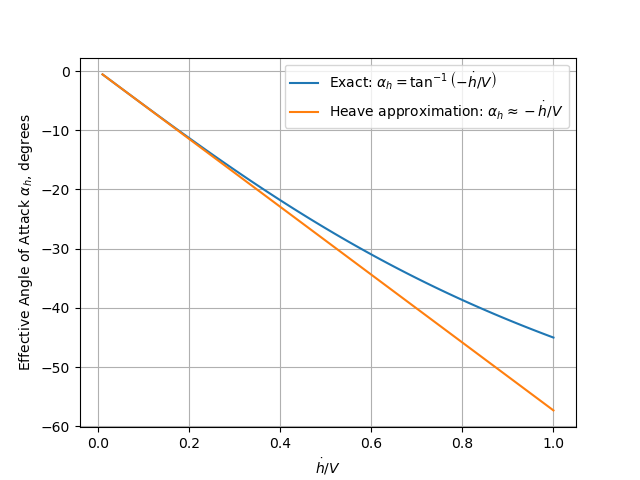

In [2]:
# Define range of ratios h_dot/V
h_dot_over_V = np.linspace(0.01, 1, 100)

# Calculate exact and approximate effective angle of attack
alpha_exact = np.arctan(-h_dot_over_V)  # radians
alpha_approx = -h_dot_over_V  # radians, small angle approximation

# Plot the exact and approximate effective angle of attack
plt.figure()
plt.plot(
    h_dot_over_V,
    np.degrees(alpha_exact),
    label="Exact: $\\alpha_h = \\tan^{-1}\\left(-\\dot{h}/V\\right)$",
)
plt.plot(
    h_dot_over_V,
    np.degrees(alpha_approx),
    label="Heave approximation: $\\alpha_h \\approx -\\dot{h}/V$",
)
plt.xlabel("$\\dot{h}/V$")
plt.ylabel("Effective Angle of Attack $\\alpha_h$, degrees")
plt.legend()
plt.grid()
plt.show()

The plot above shows that the exact and approximate formulas for the effective angle of attack match closely when the ratio $\dot{h}/V$ is below approximately 0.3, corresponding to an effective angle of attack of about 17 degrees. Beyond this point, the approximation starts to deviate significantly from the exact value. However, we also know that at these angles of attack, the thin airfoil theory also starts to break down. So, in practice, the heave approximation is going to be valid as long as we remain within the applicable range of thin airfoil theory.

At this point you might be wondering: what does "Quasi-Steady" mean? If the airfoil is in motion, things must be unsteady, so changing with time, right? The issue is that when the airfoil moves, the flow around it doesn't adjust instantly. For instance, the wake behind the airfoil takes time to change, and this affects how the forces over the airfoil evolve. What we do in quasi-steady aerodynamics is to ignore these unsteady effects and assume that the forces adjust *instantly* to the change in angle of attack. In other words, for our airfoil moving up and down, we are saying that we can prescribe whatever motion $h(t)$ we want, and at every instant in time we can calculate the aerodynamic forces using the heave approximation, which essentially treats the problem as if it was steady.

Let's visualize this by prescribing a sinusoidal heave motion and looking at the resulting lift force for different motion frequencies.

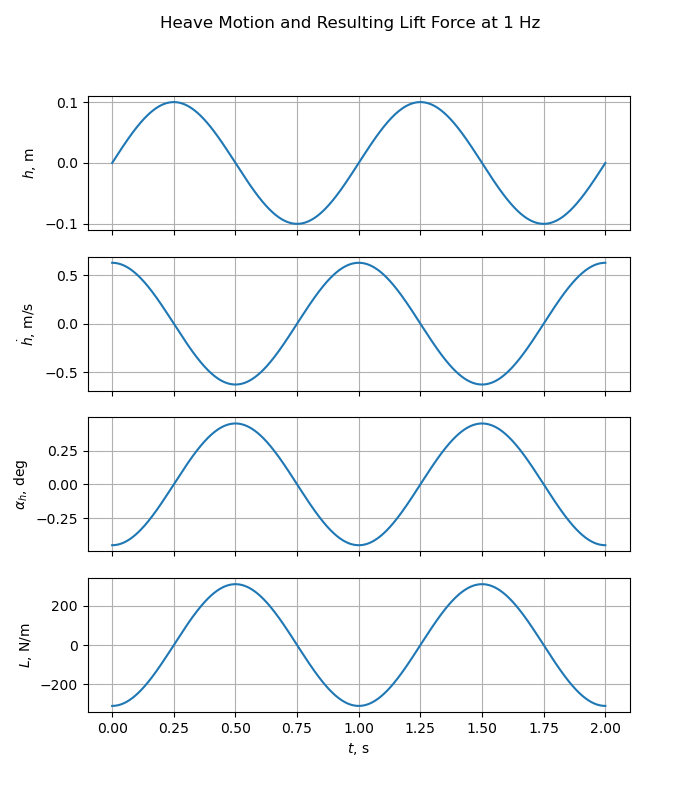

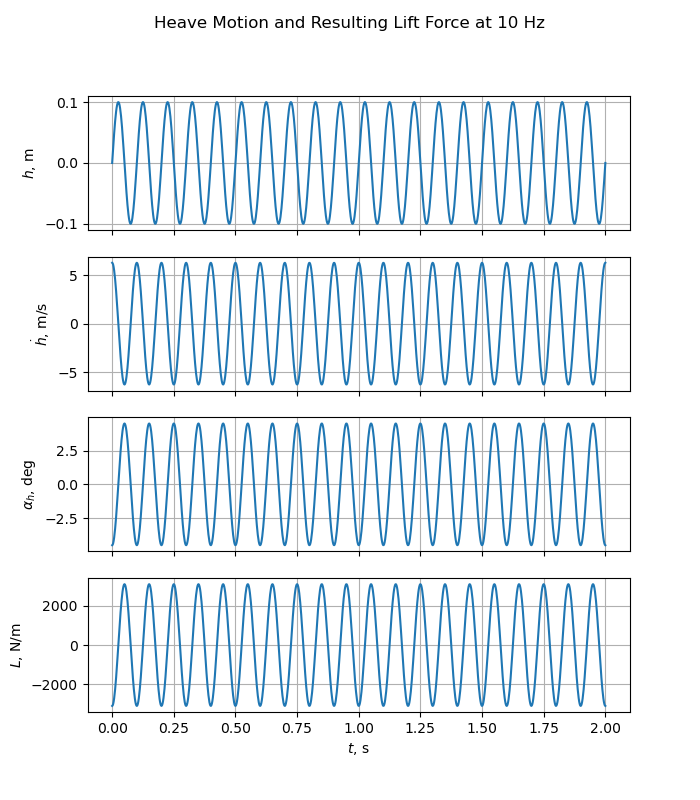

In [3]:
# Define air density, speed, chord, and lift curve slope
rho = 1.225  # kg/m^3
V = 80  # m/s
c = 1.6  # m
cl_alpha = 2 * np.pi  # per radian

# Calculate dynamic pressure
q = 0.5 * rho * V**2  # Pa

# Define time array - let's observe for 2 seconds
t = np.linspace(0, 2, 1000)  # seconds

# Define heave motion amplitude of 0.1 m
h_amp = 0.1  # m

# We investigate two frequencies: 1 Hz (lower) and 10 Hz (higher)
f_range = [1, 10]  # Hz

# Iterate over the two frequencies
for f in f_range:

    # Calculate heave motion
    h = h_amp * np.sin(2 * np.pi * f * t)  # m

    # Calculate heave velocity
    h_dot = h_amp * 2 * np.pi * f * np.cos(2 * np.pi * f * t)  # m/s

    # Calculate effective angle of attack
    alpha_h = -h_dot / V  # radians

    # Calculate lift force using quasi-steady approximation
    L = q * c * cl_alpha * alpha_h  # N

    # Plot heave, heave velocity, effective angle of attack, and lift force
    # We create four subplots one below the other (4 rows, 1 column)
    # We set the figure size to be taller for better visibility (values in inches)
    # We use sharex=True to share the x-axis (time) between the two plots
    fig, axes = plt.subplots(4, 1, figsize=(7, 8), sharex=True)

    # Plot heave motion
    axes[0].plot(t, h)
    axes[0].set_ylabel("$h$, m")
    axes[0].grid()

    # Plot heave velocity
    axes[1].plot(t, h_dot)
    axes[1].set_ylabel("$\\dot{h}$, m/s")
    axes[1].grid()

    # Plot effective angle of attack
    axes[2].plot(t, np.degrees(alpha_h))  # Convert to degrees for better readability
    axes[2].set_ylabel("$\\alpha_h$, deg")
    axes[2].grid()

    # Plot lift force
    axes[3].plot(t, L)
    axes[3].set_ylabel("$L$, N/m")
    axes[3].set_xlabel("$t$, s")
    axes[3].grid()

    # Set figure title and show the plot
    fig.suptitle(f"Heave Motion and Resulting Lift Force at {f} Hz")
    plt.show()

Let's examine the two figures. In both cases, the airfoil moves up and down with the same amplitude (0.1 m). The heave speed $\dot{h}(t)$ is the derivative of the heave motion, so it also varies harmonically but with a phase shift of 90 degrees with respect to $h(t)$ because the derivative of a sine function is a cosine function. The effective angle of attack $\alpha_h(t)$ is directly proportional to the heave speed, so it also varies harmonically, although it appears shifted by 180 degrees due to the negative sign in the heave approximation formula. As we mentioned earlier, this is because the heave motion generates an angle of attack in the opposite direction to the motion. Finally, the lift force $L(t)$ is proportional to the effective angle of attack, so it also varies harmonically and is in phase with $\alpha_h(t)$.

What is important to notice is that as we increase the frequency of the heave motion from 1 Hz to 10 Hz, the amplitude of the heave speed $\dot{h}(t)$ increases significantly (since it is proportional to frequency). Consequently, the effective angle of attack $\alpha_h(t)$ and the lift force $L(t)$ also increase in amplitude. This happens because we are assuming quasi-steady aerodynamics, where the lift responds instantaneously to changes in angle of attack. In reality, when considering full unsteady aerodynamics, the lift response would be more complex and would not increase indefinitely with frequency due to so-called _lag effects_ in the flow, meaning that the flow takes time to adjust to changes in motion.

It's always good to keep in mind the limitations of the assumptions we make. However, for the moment we don't have to worry about that. Let's move on to writing the equations of motion for our system.

## 2. The Heave-Only Typical Section and its Equation of Motion

Let's briefly recall the idea of the typical section. As we mentioned in Notebook 1, it's a simplified 2D model of a wing section that can move with three degrees of freedom. In the first notebook, we only considered the pitch degree of freedom and neglected the others. This time, we will only consider the heave degree of freedom with a translational spring ($k_h$), as shown below. In addition, since we are going to work with an object in motion and we have to take into account inertial forces, we consider the typical section to have a mass $m$.

<figure>
<p align="center">
<img src="../figures/02_typical_section_heave_dof.svg" style="width:75%">
<figcaption align = "center">  Typical section with heave degree of freedom only. </figcaption>
</p>
</figure>

Let's write Newton's Second Law ($F = ma$) for our system. What are the forces acting on the typical section in heave?

1. Elastic restoring force from the spring: $-k_h h$ (it acts opposite to the displacement).
2. Aerodynamic Lift force: $L$ (by convention when positive it acts upwards).
3. Inertial force: $m \ddot{h}$ (mass times acceleration).

Putting it all together, we have:
$$L - k_h h = m \ddot{h}$$

Using our Quasi-Steady approximation, the Lift is:

$$L = q c c_{l\alpha} \alpha_h$$

Since the only angle of attack comes from our heave motion ($\alpha_h = -\frac{\dot{h}}{V}$):

$$L = q c c_{l\alpha} \left( - \frac{\dot{h}}{V} \right)$$

Now, let's plug this back into our equation of motion.

$$ - q c c_{l\alpha} \left( \frac{\dot{h}}{V} \right) - k_h h = m \ddot{h} $$

Rearranging the terms, we have:

$$m \ddot{h} + \frac{q c c_{l\alpha}}{V} \dot{h} + k_h h = 0$$

### STOP and Look! 👀
Doesn't this equation look familiar? It's a second-order linear ordinary differential equation, just like the mass-spring-damper system we study in classical mechanics! In particular, look at the term in the middle multiplying $\dot{h}$. In mechanical systems, a term proportional to velocity is a **viscous damper**.

* The aerodynamics is acting like a shock absorber!
* Because this term can only be positive, it dissipates energy. 
* **Conclusion:** An airfoil with heave motion and quasi-steady aerodynamics will always damp its motion and never be unstable.

What else can we observe about this damping term? If we assume the chord and the lift curve slope to be fixed for our airfoil, then the only variables that affect the magnitude of this aerodynamic damping are:
* Dynamic pressure $q$ (which increases with speed and air density).
* Flight speed $V$ (in the denominator).

Since $q = \frac{1}{2} \rho V^2$, the aerodynamic damping term is essentially proportional to $\rho$ and $V$. This means that for our heave-only typical section with quasi-steady aerodynamics, the aerodynamic damping will always increase with flight speed. At the same time, if we consider higher altitudes than sea level, the air density $\rho$ decreases, which in turn reduces the aerodynamic damping.

Let's now solve the equation of motion and visualize the response of the system for different flight conditions.

## 3. Solution to the Equation of Motion and State-Space Representation

We found that the equation of motion for our heave-only typical section with quasi-steady aerodynamics is a second-order linear ordinary differential equation, similar to a mass-spring-damper system. Do you remember the solution to this kind of equation? Let's review it together!

### General Solution of the Mass-Spring-Damper System and Frequency and Damping Characteristics

The free vibration of a mass-spring-damper system is governed by the following homogeneous differential equation:

$$m \ddot{x}(t) + c \dot{x}(t) + k x(t) = 0,$$

which has the following exponential solution:

$$
x(t) = X e^{\lambda t} = X e^{\left(\lambda_r + i\lambda_i\right)t} = X e^{\lambda_r t} e^{i\lambda_i t},
$$

where $X$ is an unknown constant that depends on the initial conditions, and $\lambda = \lambda_r + i\lambda_i$ is a complex number. With the help of Euler's formula, we can see that $e^{i\lambda_i t}$ represents the oscillatory part of the solution:

$$
e^{i\lambda_i t} = \cos(\lambda_i t) + i \sin(\lambda_i t),
$$

where $\lambda_i$ represents the frequency of oscillation of the system. On the other hand, the term $e^{\lambda_r t}$ represents the exponential growth or decay of the oscillations, depending on the sign of $\lambda_r$.

To find the solution for $x(t)$, we need to determine the real and imaginary parts of $\lambda$. We differentiate $x(t)$ once and twice:

$$
\dot{x}(t) = \lambda X e^{\lambda t}\\
\ddot{x}(t) = \lambda^2 X e^{\lambda t},
$$

and we substitute these expressions into the equation of motion:

$$
m \lambda^2 X e^{\lambda t} + c \lambda X e^{\lambda t} + k X e^{\lambda t} = \left( m \lambda^2 + c \lambda + k \right) X e^{\lambda t} = 0.
$$

Since $X e^{\lambda t} \neq 0$, to find $\lambda$ we need to solve the following equation:

$$
m \lambda^2 + c \lambda + k = 0,
$$

which is called the characteristic equation of the system. The solutions of this equation are the roots of the polynomial:

$$
\lambda_{1,2} = -\frac{c \pm \sqrt{c^2 - 4mk}}{2m}.
$$

These roots can be real or complex, depending on the value of $c^2 - 4mk$.

The general solution of the homogeneous differential equation of the system is represented by the linear superposition of the individual solutions:

$$
x(t) = X_1 e^{\lambda_1 t} + X_2 e^{\lambda_2 t},
$$

where $X_1$ and $X_2$ are constants that depend on the initial conditions of the system.

It is convenient to rewrite the roots $\lambda_{1,2}$ in the following way:

$$
\lambda_{1,2} = -\frac{c \pm \sqrt{c^2 - 4mk}}{2m} = -\frac{c}{2m} \pm \left(\frac{c^2}{4m^2} - \frac{k}{m}\right)^{1/2} = -\frac{c}{2m} \pm \sqrt{\frac{k}{m}}\left(\frac{c^2}{4mk} - 1\right)^{1/2}.
$$

In this expression we can recognize the natural frequency of the undamped system $\omega_0 = \sqrt{k/m}$ and the damping ratio $\zeta = c/2\left(mk\right)^{1/2}$. Consequently, we can rewrite the roots as:

$$
\lambda_{1,2} = -\zeta \omega_0 \pm \omega_0 \left(\zeta^2 - 1\right)^{1/2}.
$$

We can then assess the nature of the roots based on the value of the damping ratio $\zeta$:
* If $\zeta < 1$, we have two complex conjugate roots and the system is underdamped.
* If $\zeta = 1$, we have one double real root ($\lambda_1=\lambda_2$) and the system is critically damped.
* If $\zeta > 1$, we have two distinct real roots and the system is overdamped.

Since aerospace structures are typically characterized by underdamped behavior, it is convenient to rewrite the roots to highlight the real and imaginary parts in the underdamped case:

$$
\lambda_{1,2} = -\zeta \omega_0 \pm i \omega_0 \sqrt{1 - \zeta^2}.
$$

Once again we highlight that the real part of the roots, $-\zeta \omega_0$, represents the rate of exponential decay or growth of the oscillations, while the imaginary part represents the frequency of oscillation $\omega$ of the system:

$$
\lambda_r = \mathbb{Re}(\lambda) = -\zeta \omega_0,\\[1ex]
\lambda_i = \mathbb{Im}(\lambda) = \omega_0 \sqrt{1 - \zeta^2} = \omega.
$$

Notice how a positive damping ratio $\zeta$ results in a negative real part $\lambda_r$, which means that the oscillations decay exponentially over time and that the system is stable. Conversely, a negative damping ratio would lead to a positive real part $\lambda_r$, resulting in exponentially growing oscillations and an unstable system.

The general solution of the system can then be rewritten as:

$$
x(t) = X_1 e^{\left(\lambda_r + i \lambda_i\right)t} + X_2 e^{\left(\lambda_r - i \lambda_i\right)t}.
$$

The key takeaway here is that by finding $\lambda_r$ and $\lambda_i$ of our system, be it the mass-spring-damper or our heave-only typical section with quasi-steady aerodynamics, we can determine the characteristics of its dynamic response, i.e. how quickly it oscillates and how quickly those oscillations grow or decay over time.

We want now to explore these characteristics in a practical way for our heave-only typical section with quasi-steady aerodynamics. Remember what we said earlier looking at the aerodynamic damping term: the free motion of our system should be damped more and more as we increase the flight speed $V$. It would be nice to actually solve the evolution of the system with time for different flight speeds and see this effect in practice. In order to do this we are going to introduce the **State-Space Representation** of our system.

### State-Space Representation

In order to find the time evolution of our system for different flight speeds in a computational environment like this notebook, it is convenient to express our second-order differential equation as a system of first-order differential equations and use numerical integration techniques to solve it.

We can use a standard "trick" to convert our 2nd-order equation into two 1st-order equations. First, we isolate the highest derivative in our equation of motion:

$$m \ddot{h} = - \left( \frac{q c c_{l\alpha}}{V} \right) \dot{h} - k_h h$$

Successively, we define a state vector $\boldsymbol{x}$:

$$\boldsymbol{x} = \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} = \begin{bmatrix} h \\ \dot{h} \end{bmatrix}$$

Now we write the derivatives:
$$
\dot{h} = \dot{x}_1 = x_2\\[1ex]
\ddot{h} = \dot{x}_2 = -\frac{1}{m} \left( \frac{q c c_{l\alpha}}{V} \dot{h} + k_h h \right)
$$

Finally we assemble everything in matrix form:

$$\begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \end{bmatrix} = \begin{bmatrix} 0 & 1 \\ -\frac{k_h}{m} & -\frac{q c c_{l\alpha}}{m V} \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix},$$

or more compactly:

$$\dot{\boldsymbol{x}} = \boldsymbol{A} \boldsymbol{x},$$

where $\boldsymbol{A}$ is called the **system matrix**. The expression above is called the **state-space representation** of our system, and essentially it consists in expressing the time derivative of the state vector $\boldsymbol{x}$ as a linear combination of the states themselves.

Let's define a function that builds the system matrix $\boldsymbol{A}$ for a given dynamic pressure and flight speed, assuming we keep all other parameters fixed. We will use this function later to simulate the time evolution of our system for different flight speeds.

In [4]:
# Let's define the missing system parameters
m = 200.0  # mass per unit span (kg/m)
k_h = 2e3  # heave stiffness (N/m)


# Here we define the function to build the system matrix
# Since we want to investigate how the dynamic response changes with flight speed,
# we will pass dynamic pressure and velocity as arguments to the function and
# assume other parameters are fixed (m, k_h, c, cl_alpha)
def build_system_matrix(dynamic_pressure, velocity):
    """
    Constructs the system matrix A for the 1-DOF heave model.

    Parameters:
    dynamic_pressure (float): Dynamic pressure (N/m^2)
    velocity (float): Flight speed (m/s)

    Returns:
    system_matrix (numpy array): 2x2 system matrix
    """
    # When writing a function, we try to name variables in a way that they do not shadow the global variables

    # Assemble system matrix
    # Row 1: [0, 1]
    # Row 2: [-kh/m, -q*S*cl_alpha/(m*V)]
    # Note: the function can access global variables m, k_h, c, cl_alpha
    system_matrix = np.array(
        [[0, 1], [-k_h / m, -dynamic_pressure * c * cl_alpha / (m * velocity)]]
    )

    # Return the system matrix
    return system_matrix

## 4. Time Domain Simulation

Now that we have our system matrix $A$, how does our typical section actually move?

To find out, we need to solve the differential equation in time. In Python, the standard tool for this is the `odeint` function from the `integrate` module of the `scipy` library. It takes our system of equations and numerically integrates them step-by-step.

Let's simulate the response of our wing to an initial disturbance. Imagine we pull the wing up by 0.5 m ($h_0 = 0.5$ m) and let go. What happens at different speeds?

We will test three speeds:
1.  **Low Speed (40 m/s):**
2.  **Medium Speed (80 m/s):**
3.  **High Speed (230 m/s):**

How do we use the function `odeint` to simulate our system? The call to `odeint` requires:
1. A function that computes the derivatives of the state vector $\dot{\boldsymbol{x}}$ at each time step.
2. The initial state vector $\boldsymbol{x}_0$.
3. A time array over which to integrate.
4. Any additional arguments needed by the derivative function.

Let's first define the derivative function. This function will compute $\dot{\boldsymbol{x}}$ using our system matrix $\boldsymbol{A}$.

In [5]:
from scipy.integrate import odeint


# Define the function that returns dx/dt = A * x
def state_space_model(x, time_array, system_matrix):
    """
    Computes the derivative of the state vector.

    Parameters:
    x (array): State vector [h, h_dot]
    time_array (float): Time (not used here because our system is linear time-invariant, but odeint requires it)
    system_matrix (matrix): System matrix

    Returns:
    dxdt (array): Time derivative of the state vector
    """
    dxdt = system_matrix @ x
    return dxdt

Let's now try to run the simulation for $V = 40$ m/s and visualize the results.

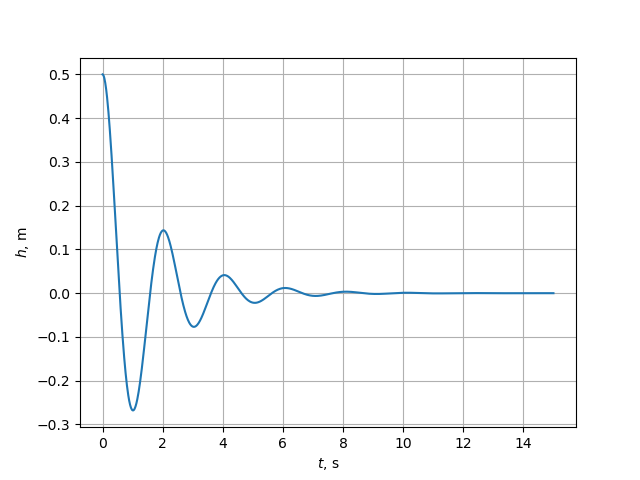

In [6]:
# Define flight speed
V = 40  # m/s

# Calculate dynamic pressure
q = 0.5 * rho * V**2  # Pa

# Build the system matrix for this speed
A = build_system_matrix(q, V)

# Define simulation parameters
t = np.linspace(0, 15, 1000)  # Simulate for 2 seconds
initial_condition = [0.5, 0.0]  # Initial displacement h = 0.5 m, h_dot = 0 m/s

# Solve the ODE
# args=(A,) passes the matrix A to our function
# odeint returns the solution array in which each column corresponds to a state variable (h and h_dot)
solution_array = odeint(state_space_model, initial_condition, t, args=(A,))

# Extract 'h' (the first column of the solution)
h_response = solution_array[:, 0]

# Plot the time response
plt.figure()
plt.plot(t, h_response)
plt.xlabel("$t$, s")
plt.ylabel("$h$, m")
plt.grid(True)
plt.show()

As expected, the motion is damped over time. The typical section oscillates up and down with a period of about 2 seconds, and the amplitude of the oscillations decreases over time due to the aerodynamic damping.

Let's now run the simulation for all three speeds and plot the results together for comparison.

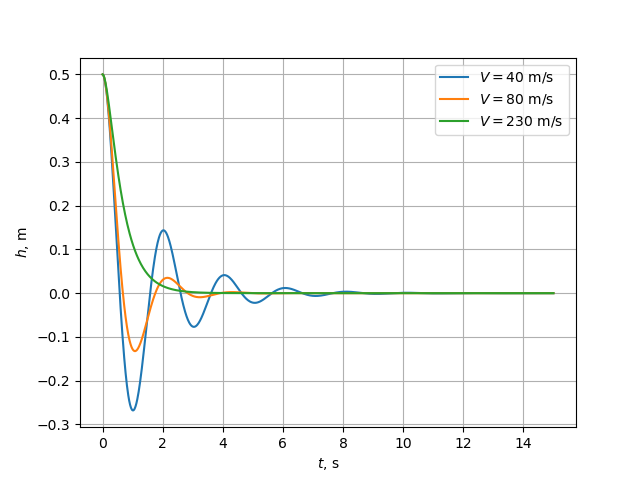

In [7]:
# Define flight speeds to test
flight_speeds = [40, 80, 230]

# Create figure
plt.figure()

# Iterate over speeds
for V in flight_speeds:

    # Calculate dynamic pressure
    q = 0.5 * rho * V**2  # Pa

    # Build the system matrix for this speed
    A = build_system_matrix(q, V)

    # Solve the ODE
    solution_array = odeint(state_space_model, initial_condition, t, args=(A,))

    # Extract 'h' (the first column of the solution)
    h_response = solution_array[:, 0]

    # Plot
    plt.plot(t, h_response, label=f"$V = {V}$ m/s")

# Set axes labels, legend, and grid
plt.xlabel("$t$, s")
plt.ylabel("$h$, m")
plt.legend()
plt.grid(True)
plt.show()

As you can see the motion is damped more quickly as we increase the flight speed from 40 m/s to 80 m/s, while the oscillation frequency remains roughly the same (can you say why?). What happens at 200 m/s? The motion is no longer oscillatory; instead, the system returns to equilibrium without oscillating. This indicates that at this high speed, the aerodynamic damping is so strong that the system is actually overdamped instead of underdamped, leading to a non-oscillatory return to equilibrium.

Question for you now: what happens at $V = 0$ m/s? Try to predict the motion of the system before running the simulation, and then verify your prediction by implementing the simulation for this case. Be careful, something will happen and you will have to think about how to handle it!

In [8]:
# Define flight speed
# ...

# Calculate dynamic pressure
# ...

# Build the system matrix for this speed
# ...

# Solve the ODE
# ...

# Extract 'h' (the first column of the solution)
# ...

# Plot the time response
# ...

The three cases we analyzed earlier (40 m/s, 80 m/s, and 200 m/s) are useful to go back to some of the concepts we reviewed about the mass-spring-damper system. In particular, we can now relate the observed motion to the roots of the characteristic equation of the system. In fact, without solving the ODE in time, we could have determined the nature of the motion just by looking at the real and imaginary parts of those roots. For instance, at 40 m/s and 80 m/s, the roots are complex conjugates with negative real parts, indicating underdamped oscillatory motion. In addition, the real part becomes more negative as we increase the speed, indicating stronger damping, while the imaginary part does not change significantly. At 200 m/s, the roots become real and negative, indicating overdamped motion without oscillations.

For this reason, it is often more convenient to analyze the characteristics of the system by looking at these roots and how they change with flight speed, rather than simulating the time response every time. This is what we will do next.

## 5. Eigenvalue Analysis and Root Locus

To determine the characteristics of our system without simulating the time response, we can calculate the **eigenvalues** of matrix $\boldsymbol{A}$. Wait a second, why are we talking about eigenvalues now? I'll tell you more, the eigenvalues of the system matrix $\boldsymbol{A}$ are exactly the roots of the characteristic equation we derived earlier, so precisely what we are looking for! Let's unpack this together.

If for a system $\dot{\boldsymbol{x}} = \boldsymbol{A} \boldsymbol{x}$ we assume a solution of the form $\boldsymbol{x}(t) = \hat{\boldsymbol{x}} e^{\lambda t}$, we can substitute this assumed solution into the differential equation:

$$\lambda \hat{\boldsymbol{x}} e^{\lambda t} = \boldsymbol{A} \hat{\boldsymbol{x}} e^{\lambda t}.$$

Note that the assumed solution $\boldsymbol{x}(t) = \hat{\boldsymbol{x}} e^{\lambda t}$ is essentially the same type of solution we used earlier for the mass-spring-damper system. The only difference here is that we are solving for a system of equations instead of a single equation, and therefore $\hat{\boldsymbol{x}}$ is a vector instead of a scalar. This vector has the same dimension as our state vector $\boldsymbol{x}$, and in the specific case of our heave-only typical section, it has two unknown constants: one for the heave displacement and one for the heave velocity.

Since $\hat{\boldsymbol{x}} e^{\lambda t}$ must be non-zero for a non-trivial solution, we can divide both sides by it, leading to:

$$\lambda \hat{\boldsymbol{x}} = \boldsymbol{A} \hat{\boldsymbol{x}}.$$
This is the definition of an eigenvalue problem, where $\lambda$ is the eigenvalue of the assumed solution and $\hat{\boldsymbol{x}}$ is the corresponding eigenvector. To find the eigenvalues, we need to solve the characteristic equation:

$$\text{det}(\boldsymbol{A} - \lambda \boldsymbol{I}) = 0,$$

where $\boldsymbol{I}$ is the identity matrix. The solutions $\lambda$ of this equation are the eigenvalues of matrix $\boldsymbol{A}$, and the general solution of the system can be expressed as a linear combination of the eigenmodes associated with these eigenvalues:

$$\boldsymbol{x}(t) = \sum_{j} c_j \hat{\boldsymbol{x}}_j e^{\lambda_j t},$$

where $\hat{\boldsymbol{x}}_j$ are the eigenvectors corresponding to the eigenvalues $\lambda_j$, and $c_j$ are constants determined by the initial conditions. For our 2x2 system matrix $\boldsymbol{A}$, we will have two eigenvalues $\lambda_1$ and $\lambda_2$, and consequently the general solution will have the same form as the one we derived earlier for the mass-spring-damper system.

Now that we've understood the connection between eigenvalues and the roots of the characteristic equation, we can compute the eigenvalues of our system matrix $\boldsymbol{A}$ for the three flight speeds we analyzed earlier (40 m/s, 80 m/s, and 200 m/s) and see how they relate to the observed motion. Remember that the real part of the eigenvalues indicates the rate of exponential decay or growth of the oscillations, while the imaginary part indicates the frequency of oscillation.

In [9]:
# Iterate over speeds
for V in flight_speeds:

    # Calculate dynamic pressure
    q = 0.5 * rho * V**2

    # Build the system matrix for this speed
    A = build_system_matrix(q, V)

    # Compute eigenvalues
    # We use the eigvals function from the linear algebra module of NumPy
    eigenvalues = np.linalg.eigvals(A)

    # Print eigenvalues
    print(f"Flight Speed: {V} m/s, Eigenvalues: {eigenvalues}")

Flight Speed: 40 m/s, Eigenvalues: [-0.61575216+3.10174939j -0.61575216-3.10174939j]
Flight Speed: 80 m/s, Eigenvalues: [-1.23150432+2.91262718j -1.23150432-2.91262718j]
Flight Speed: 230 m/s, Eigenvalues: [-1.94819596 -5.13295389]


See? The eigenvalues at 40 m/s and 80 m/s are complex conjugates with negative real parts, indicating underdamped oscillatory motion. The real part becomes more negative as we increase the speed, indicating stronger damping, while the imaginary part does not change significantly (also in the time history we saw that the oscillation frequency remained roughly the same). At 230 m/s, the eigenvalues become real and negative, indicating overdamped motion without oscillations.

### The Root Locus Plot

So far, we have computed the eigenvalues for just a few discrete flight speeds. However, it would be more informative to see how the eigenvalues change continuously as we vary the flight speed. This is where the **root locus plot** comes into play.

A root locus plot is a graphical representation that shows how the eigenvalues of a system change as a specific parameter varies. It consists in plotting the eigenvalues in the complex plane (real part vs. imaginary part) for a range of values of the parameter of interest. Typically, the points in the root locus plot are colored according to the value of the parameter, allowing us to visualize how the eigenvalues move in the complex plane as the parameter changes. In our case, we will plot the eigenvalues of our heave-only typical section with quasi-steady aerodynamics as a function of flight speed $V$. This will allow us to visualize how the dynamic characteristics of the system evolve with speed.

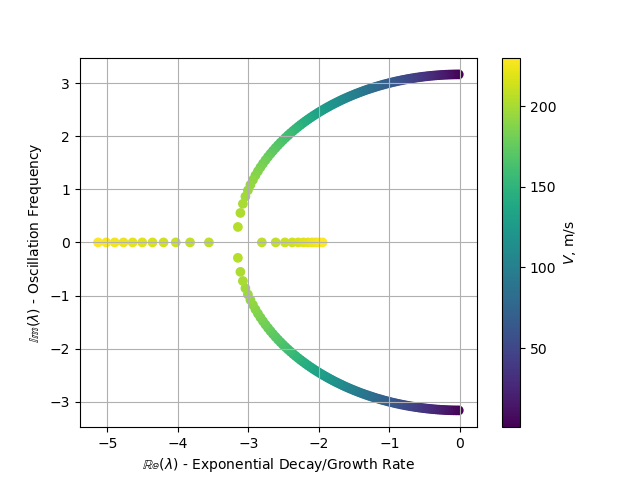

In [10]:
# Range of velocities to analyze
velocities = np.linspace(1, 230, 100)

# Initialize arrays to store real and imaginary parts of eigenvalues
# To plot the root locus, we will use the pyplot function scatter, which expects 1D arrays
# We know there will be 2 eigenvalues for each velocity, so we preallocate a 1D array with shape (N_velocities * 2,)
real_parts = np.zeros((len(velocities) * 2,))
imag_parts = np.zeros((len(velocities) * 2,))

# Iterate over velocities
for idx, V in enumerate(velocities):

    # Calculate dynamic pressure
    q = 0.5 * rho * V**2  # Pa

    # Build system matrix
    A = build_system_matrix(q, V)

    # Compute eigenvalues
    eigenvalues = np.linalg.eigvals(A)

    # Store real and imaginary parts
    # Since we have 2 eigenvalues for each velocity, we store them in the appropriate slice of the preallocated arrays
    real_parts[idx * 2 : (idx + 1) * 2] = eigenvalues.real
    imag_parts[idx * 2 : (idx + 1) * 2] = eigenvalues.imag

# Create figure
plt.figure()

# Scatter plot: x=Real, y=Imaginary, Color=Speed
# The arrays including the real and imaginary parts have shape (N_velocities * 2,)
# In order to color the points according to velocity, we need to repeat each velocity twice to match the structure of the real_parts and imag_parts arrays
# We use the repeat function from NumPy to achieve this
# The function call np.repeat(velocities, 2) creates an array where each element of the velocity array is repeated twice consecutively
# The scatter function returns a PathCollection object that we can use to create the colorbar
sc = plt.scatter(real_parts, imag_parts, c=np.repeat(velocities, 2))

# Set plot elements
plt.xlabel("$\\mathbb{Re}(\\lambda)$ - Exponential Decay/Growth Rate")
plt.ylabel("$\\mathbb{Im}(\\lambda)$ - Oscillation Frequency")
plt.grid(True)

# Add colorbar and show plot
plt.colorbar(sc, label="$V$, m/s")
plt.show()

Let's interpret the root locus plot together.

1.  The imaginary axis, so $\mathbb{Re}(\lambda) = 0$, is the **boundary of stability**:
    * Left side (negative real part) = Stable.
    * Right side (positive real part) = Unstable.
2.  **Our Trajectory:** Look at the dots. As speed increases (color changes from blue to yellow):
    * We start with complex conjugate eigenvalues (underdamped motion) at low speeds (blue dots), where they are the closest to the imaginary axis (very small damping).
    * They move further to the **left** (more negative real part, larger damping) and towards the imaginary axis (smaller frequency) as speed increases.
    * At a certain speed, they become two distinct real eigenvalues (overdamped motion), meaning the system no longer has an oscillatory response.
    * Above this speed, one eigenvalue moves further left (more damping), while the other moves closer to zero (less damping).
3.  Confirming what we mentioned earlier in the notebook, the heave-only typical section with quasi-steady aerodynamics is always stable, as all eigenvalues remain in the left half of the complex plane for all flight speeds.

## 6. Exercise - Exploring the Effect of Mass, Spring Stiffness and Altitude

So far, we have analyzed how the dynamic characteristics of our heave-only typical section with quasi-steady aerodynamics change with flight speed, keeping all other parameters constant. Now it's your turn to explore how changes in other parameters affect the system's behavior. Specifically, you will investigate the effects of:
1. Mass ($m$)
2. Spring stiffness ($k_h$)
3. Altitude (which affects air density $\rho$, you can reuse the information from Notebook 1)

Remember to investigate this effects one at a time, and at constant flight speed.

### Instructions

1. Choose one of the parameters to vary (mass, spring stiffness, or altitude).
2. Define a reasonable range for the chosen parameter.
3. For each value of the chosen parameter, compute the eigenvalues of the system matrix $\boldsymbol{A}$ at a fixed flight speed.
4. Plot the root locus for the varying parameter, coloring the points according to the parameter value.
5. Choose a couple of specific values of the parameter and simulate the time response of the system to an initial disturbance (similar to what we did in Section 4).
6. Analyze and interpret the results. How does changing the parameter affect the dynamic characteristics of the system?

In [11]:
# Code here your exercises and enjoy!
# ...

## 7. Recap & Conclusion: The "Boring" Stability of Heave

Congratulations on completing Notebook 2! Let's take a moment to summarize what we've discovered about our Heave-Only model.

### Key Takeaways
1.  **Quasi-Steady Aerodynamics:** We assumed that the lift adjusts *instantly* to changes in the angle of attack. This is a valid approximation as long as the airfoil isn't oscillating too fast compared to the flight speed ($V \gg \dot{h}$).
2.  **Nature's Shock Absorber:** We mathematically proved that for an airfoil moving only in heave (up and down), the aerodynamic forces act purely as a **damper**. The lift generated by the motion opposes the velocity ($\dot{h}$), sucking energy out of the system.
3.  **Always Stable:** Because the aerodynamic term acts like a viscous damper, the system is **unconditionally stable**. No matter how fast we fly, an airfoil restricted to pure vertical motion will never flutter; it will just stop oscillating faster.

### The Missing Ingredient...
If the aerodynamics just adds damping, how do planes actually flutter? 
History (and disaster videos) tells us that airplanes *do* break off due to flutter, so our model is missing something crucial.

The secret ingredient we are missing is **Coupling**. Real wings don't just bend up and down; they also twist. When these two motions interact, energy can be transferred from the airflow to the structure, potentially leading to **Flutter Instability**.

### Coming Up Next: The 2-DOF Heave-Pitch Model
In **Notebook 3**, we will add again the pitch DOF, this time on top of the heave DOF. We will:
1.  Couple the Heave and Pitch equations together (2 Degrees of Freedom).
2.  See how the "Stiffness" and "Damping" matrices become populated with off-diagonal terms.
3.  Witness our first **Flutter Instability** using the same Quasi-Steady aerodynamics.

Get ready, because the eigenvalues are about to cross the imaginary axis! 🚀

---
**End of Notebook 2**
*Save your work and proceed to Notebook 3!*